#  Mining Software Repositories - 101

A few possible things to gather from any Git Repo by using `Python` and `GitPython`.

The implementations viewed here are *examples*. There probably are more *efficient* ways to do most of what is shown here, but this notebook aims to give basic examples to motivate the study of Git Repos.

## Startup

First of all you'll need to install `gitpython`. You can check on how to [Here](https://gitpython.readthedocs.io/en/stable/). Assuming you already have `Python3` installed, all you need to do is type the following in your terminal:

```bash
pip install gitpython
```

After doing so, create your `.py` file, and lets get started.

In [14]:
from git import Repo
# we will also use Regex and time manipulation for this project, so lets add those as well
import time
import re as regex
# we might as well generate some plots
import matplotlib.pyplot as plt

We will need a repo to use. GitPython allows you to clone by using a simple function:

In [2]:
# Repo.clone_from(repo_url, directory_to_clone_onto)
# This example will clone the repo 'lime-csharp' from 'takenet' onto the './lime-chsarp'
try:
    Repo.clone_from('https://github.com/takenet/lime-csharp', './lime-csharp')
except:
    print('Repo already cloned or folder not empty. Skipping')

If you already have a repo you want to use, you can simply select it:

In [3]:
# Repo(repo_folder)
# We are selecting the above-cloned repo
repo = Repo('./lime-csharp')

We now have a cloned and referenced repo to use.

Lets start as simple as it gets: how many commits does the repo have?

In [4]:
# Create an iterable with all commits from the repo
allCommits = repo.iter_commits()

# Count how many commits exist
totalCommits = 0
while True:
    try:
        element = next(allCommits)
        totalCommits += 1
    except StopIteration:
        break;
print('Total number of repo commits: %d'%totalCommits)

Total number of repo commits: 1151


We can also filter those commits. For example, we can filter for commits only on 2017. To do so, we will use the attribute `committed_date` from the commit element:

In [5]:
allCommits = repo.iter_commits()
latest = next(allCommits)
print('Commit: ', latest)
print('Committed date: ', latest.committed_date)

Commit:  9bf513720b9f4019ef9fc4836bfab9608d817224
Committed date:  1551994040


While we're here, lets see some other stuff we got using the `commit` object:

In [7]:
print('Committer: ', latest.committer)
print('Committer email: ', latest.committer.email)
print('Author: ', latest.author)
print('Author email: ', latest.author.email)
print('Authored date: ', latest.authored_date)
print('Commit message: ', latest.message)
print('Files edited, with deletions and insertions: ', latest.stats.files)
print('Parents: ', latest.parents)
print('Parents author: ', latest.parents[0].author)
# And so on...

Committer:  André Bires
Committer email:  andrebires@gmail.com
Author:  André Bires
Author email:  andrebires@gmail.com
Authored date:  1551994040
Commit message:  Allow passing ssl and http protocols to kestrel websocket transport listener

Files edited, with deletions and insertions:  {'src/Lime.Transport.WebSocket/Kestrel/KestrelWebSocketTransportListener.cs': {'insertions': 5, 'deletions': 3, 'lines': 8}}
Parents:  (<git.Commit "07477f06430a782b6cdc0f00282a3e103fdc200c">,)
Parents author:  André Bires


More information can be seen [here](https://gitpython.readthedocs.io/en/stable/tutorial.html#the-commit-object)

Back into mining. Lets see one way to check all commits made on 2017:

In [16]:
# get the commit's year
def GetCommitYear(element):
    return time.strftime("%Y", time.gmtime(element.committed_date))

allCommits = repo.iter_commits()
count = 0
while True:
    try:
        element = next(allCommits)
        if(GetCommitYear(element)=='2017'):
            count += 1
    except StopIteration:
        break
print('Total commits in 2017: ', count)

Total commits in 2017:  118


With such filters, we can generate some interesting plots:

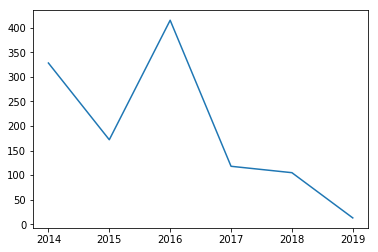

In [23]:
allCommits = repo.iter_commits()
count = 0
dictionary = {}
while True:
    try:
        element = next(allCommits)
        commitYear = GetCommitYear(element)
        if commitYear in dictionary:
            dictionary[commitYear] = dictionary[commitYear] + 1
        else:
            dictionary[commitYear] = 1
    except StopIteration:
        break
        
dates = list(dictionary.keys())           # list() needed for python 3.x
prices = list(dictionary.values())        # ditto
dates.reverse()
prices.reverse()
plt.plot_date(dates, prices, '-') # this will show date at the x-axis

We can filter even more, to commits on that year AND made by a given author:

In [24]:
allCommits = repo.iter_commits()
count = 0
while True:
    try:
        element = next(allCommits)
        if(GetCommitYear(element)=='2017' and element.author.email=='andrebires@gmail.com'):
            count += 1
    except StopIteration:
        break
print('Total commits by \'andrebires@gmail.com\' in 2017: ', count)

Total commits by 'andrebires@gmail.com' in 2017:  45


We can also try to predict the importance of a given commit by it's message. A few common keywords to indicate important commits are 'fix' or 'feature'. Lets try those:

In [25]:
def GetCommitsWithMessage(repo, message):
    allCommits = repo.iter_commits()
    count = 0
    while True:
        try:
            element = next(allCommits)
            if(element.message.find(message)>=0):
                count = count + 1
        except StopIteration:
            break
    return count

commitsWithFix = GetCommitsWithMessage(repo, 'fix')
commitsWithFeature = GetCommitsWithMessage(repo, 'feature')
print('Commits with message containing \'fix\': ', commitsWithFix)
print('Commits with message containing \'feature\': ', commitsWithFeature)

Commits with message containing 'fix':  35
Commits with message containing 'feature':  4


Now, lets say you want to check what files are most important. One way to try to identify them is to check which files are most modified.

In [26]:
allCommits = repo.iter_commits()
dictionary = {}
count = 0
while True:
    try:
        element = next(allCommits)
        for key in element.stats.files:
            if key in dictionary:
                dictionary[key] = dictionary[key] + 1
            else:
                dictionary[key] = 1
    except StopIteration:
        break
print("Top 10 modified files:")
for key, value in sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True):
    print (key, value)
    count = count + 1
    if count == 10:
        break

Top 10 modified files:
src/Lime.Client.TestConsole/Lime.Client.TestConsole.csproj 122
src/Lime.Protocol/Lime.Protocol.csproj 103
src/Lime.Protocol.UnitTests/Lime.Protocol.UnitTests.csproj 88
src/Lime.Protocol.UnitTests/Network/ChannelBaseTests.cs 81
src/Lime.Protocol/Network/ChannelBase.cs 74
src/Lime.sln 58
src/Lime.Client.TestConsole/Templates.txt 53
src/Lime.Protocol.UnitTests/Client/ClientChannelTests.cs 47
src/Lime.Client.Windows/Lime.Client.Windows.csproj 47
src/Lime.Client.TestConsole/ViewModels/SessionViewModel.cs 46


That isn't exactly as precise as we need: files with extensions like `.csproj` or `.txt` aren't as relevant as `.cs`. Lets filter that as well:

In [27]:
allCommits = repo.iter_commits()
dictionary = {}
count = 0
while True:
    try:
        element = next(allCommits)
        for key in element.stats.files:
            if(key.endswith('.cs')):
                if key in dictionary:
                    dictionary[key] = dictionary[key] + 1
                else:
                    dictionary[key] = 1
    except StopIteration:
        break
print("Top 10 modified files:")
for key, value in sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True):
    print (key, value)
    count = count + 1
    if count == 10:
        break

Top 10 modified files:
src/Lime.Protocol.UnitTests/Network/ChannelBaseTests.cs 81
src/Lime.Protocol/Network/ChannelBase.cs 74
src/Lime.Protocol.UnitTests/Client/ClientChannelTests.cs 47
src/Lime.Client.TestConsole/ViewModels/SessionViewModel.cs 46
src/Lime.Protocol/Serialization/TypeUtil.cs 45
src/Lime.Protocol.UnitTests/Network/Modules/ResendMessagesChannelModuleTests.cs 43
src/Lime.Protocol.UnitTests/Serialization/EnvelopeSerializerTests.cs 43
src/Lime.Protocol/Lime.Protocol/Network/ChannelBase.cs 43
src/Lime.Transport.WebSocket/WebSocketTransport.cs 40
src/Lime.Protocol/Client/ClientChannel.cs 38


Another useful metric is who are the repo's most active committers:

In [28]:
allCommits = repo.iter_commits()
dictionary = {}
count = 0
while True:
    try:
        element = next(allCommits)
        if element.author.name in dictionary:
            dictionary[element.author.name] = dictionary[element.author.name] + 1
        else:
            dictionary[element.author.name] = 1
    except StopIteration:
        break
print('Top 10 Committers:')
for key, value in sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True):
    print (key, value)
    count = count + 1
    if count == 10:
        break

Top 10 Committers:
André Bires 589
André Bires Fonseca 203
André Bires Fonseca (Takenet) 106
André C. O. Minelli 77
Rafael Avelar Pacheco 39
GabrielBico 26
Aldo Catella (Takenet) 22
aldo 21
André Minelli 16
Nicolas Bontempo 11


With that information we can even generate a commit-plot:

([<matplotlib.axis.XTick at 0x11af59438>,
 <a list of 25 Text xticklabel objects>)

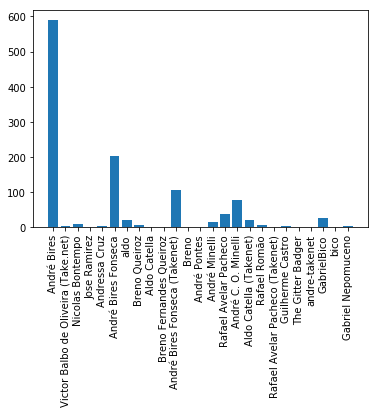

In [29]:
plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
plt.xticks(range(len(dictionary)), list(dictionary.keys()), rotation='vertical')

From that we get a very interesting metric: the project is *highly* dependant on 'André Bires', as he has **over half the commits of the entire repo**:

In [30]:
count = 0
for key, value in sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True):
    if(key.find('André Bires')>=0):
        count += value
print('André Bires\'s commits: ', count)
print('Total commits: ', totalCommits)
print('Ratio: ', count/totalCommits)

André Bires's commits:  898
Total commits:  1151
Ratio:  0.7801911381407471


Lastly (for this *basics* guide, at least), you can check how many times a given `string` was added or removed from a line. Lets check for example how many times a `List<*>` object was created, and how many times the same type of object was removed:

In [31]:
def FindAddsOrRemoves(add):
    allCommits = repo.iter_commits()
    total = 0
    if(add):
        searchRegex = r"\+.*List<.*>.*\n"
    else:
        searchRegex = r"\-.*List<.*>.*\n"
    while True:
        try:
            element = next(allCommits)
            nextCommit = next(allCommits)
            # by using the 'repo.git' object you can issue all sorts of git commands.
            # reference for that can be found here: https://gitpython.readthedocs.io/en/stable/tutorial.html#using-git-directly
            diff = repo.git.diff(element, nextCommit)
            allLists = regex.findall(searchRegex, diff)
            total = total + len(allLists)
        except StopIteration:
            print("Number of \'List<*>\' Edits: %d %s" % (total, "adds" if add else "removes"))
            break

FindAddsOrRemoves(True)
FindAddsOrRemoves(False)

Number of 'List<*>' Edits: 108 adds
Number of 'List<*>' Edits: 154 removes


A complete `Python Script` containing the above examples (with a few extra filters) can be found [here](https://github.com/lfmundim/MinRepoSoft/blob/master/Exercicio1/main.py)

In [49]:
# clearing the cloned repo
import shutil
shutil.rmtree('./lime-csharp', ignore_errors=True)